In [1]:
##### Always import all needed libraries in the first cell
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.svm import SVC
import pandas as pd
from string import punctuation
import os
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from keras.models import Sequential
from keras import layers
from keras.layers import Reshape
from keras import metrics
from keras import backend as K
from keras.utils import multi_gpu_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

np.random.seed(1) # this sets the seed so that the runs are consistent

%matplotlib inline

Using TensorFlow backend.


In [2]:
def cross_val(clf,X,y,name):
    print(name)
    y_pred = cross_val_predict(clf, X, y, cv=10)
    print(metrics.classification_report(y, y_pred))
    conf = np.array(metrics.confusion_matrix(y, y_pred))
    print(conf)
    y_probas = clf.predict_proba(X)
#     skplt.metrics.plot_roc_curve(y, y_probas, title=name+' ROC Curves', curves='each_class')
    return metrics.f1_score(y,y_pred,pos_label=1, average='binary')

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [3]:
dftrain_banned = pd.read_csv("../Data/Generated/200_words_10M_banned.csv", delimiter=',')
dftrain_banned.insert(0, "banned", 1)

dftrain_notbanned = pd.read_csv("../Data/Generated/200_words_10M_notbanned.csv", delimiter=',')
dftrain_notbanned.insert(0, "banned", 0)

dfTest = pd.read_csv("../Data/Generated/200_words_10M_test.csv", delimiter=',')
dfTest = dfTest.sample(frac=1)

dfTest["split"] = dfTest["words"].map(lambda x: x.split(" "), na_action='ignore')
dfTest["word_cnt"] = dfTest["split"].map(lambda x: len(x), na_action='ignore')
print("Test percent lost: %.2f" % (100*len(dfTest[dfTest["word_cnt"] != 200])/ len(dfTest)))
dfTest = dfTest[dfTest["word_cnt"] == 200]

dfTest_banned = dfTest[dfTest["banned"]]
dfTest_notbanned = dfTest[dfTest["banned"] == False]


Test percent lost: 5.63


In [4]:
TRAIN_BALANCE_RATIO = 20
TEST_BALANCE_RATIO = 1
TRAIN_N_COMMENTS = int(len(dftrain_banned)/5)
TEST_N_COMMENTS = int(len(dfTest_banned)/1)

In [5]:
dfTest_balanced = pd.concat([dfTest_banned.head(n=TEST_N_COMMENTS), dfTest_notbanned.head(n=TEST_BALANCE_RATIO*TEST_N_COMMENTS)]).sample(frac=1)

In [6]:
dfTrain = pd.concat([dftrain_banned.head(n=TRAIN_N_COMMENTS), dftrain_notbanned.head(n=TRAIN_BALANCE_RATIO*TRAIN_N_COMMENTS)])

In [7]:
dfTrain[dfTrain["banned"]==1].shape, dfTrain[dfTrain["banned"]==0].shape

((1500, 2), (30000, 2))

In [8]:
dfTrain["split"] = dfTrain["words"].apply(lambda x: x.split(" "))
dfTrain["word_cnt"] = dfTrain["split"].apply(lambda x: len(x))
print("Train percent lost: %.2f" % (100*len(dfTrain[dfTrain["word_cnt"] != 200])/ len(dfTrain)))
dfTrain = dfTrain[dfTrain["word_cnt"]== 200]

Train percent lost: 0.11


In [9]:
dfTrain = dfTrain.sample(frac=1)
dfTrain.head(n=10)

,banned,words,split,word_cnt
20661,0,the best way to address our issues . Do n't tr...,"[the, best, way, to, address, our, issues, ., ...",200
18962,0,only one episode . what does one thing have to...,"[only, one, episode, ., what, does, one, thing...",200
6636,0,. Maybe he should n't act like a douche bag an...,"[., Maybe, he, should, n't, act, like, a, douc...",200
2083,0,"it . Freezing rain , we get that once in a whi...","[it, ., Freezing, rain, ,, we, get, that, once...",200
5617,0,to . ^ This guy gets it . [ ] ( /derpyhappy ) ...,"[to, ., ^, This, guy, gets, it, ., [, ], (, /d...",200
9976,0,was *that good* . Which makes it even more of ...,"[was, *that, good*, ., Which, makes, it, even,...",200
7427,0,humanity is Voldemort 's defining trait ! So t...,"[humanity, is, Voldemort, 's, defining, trait,...",200
1708,0,the end it 's not fair to evaluate individuals...,"[the, end, it, 's, not, fair, to, evaluate, in...",200
23243,0,watching TNG I always thought they were saying...,"[watching, TNG, I, always, thought, they, were...",200
22,0,did someone do some solid testing on this ? Th...,"[did, someone, do, some, solid, testing, on, t...",200


In [10]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(dfTrain["words"])
y_train = dfTrain["banned"]

X_test = vectorizer.transform(dfTest_balanced["words"])
y_test = dfTest_balanced["banned"]

In [11]:
input_dim = X_train.shape[1]  # Number of features
print(X_train.shape)
print(input_dim)

model = Sequential()


model.add(layers.Dense(30, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.5))


# model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
# model.add(layers.Dropout(0.5))


model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
# model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

(31466, 142111)
142111




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
parallel_model = multi_gpu_model(model, gpus=8, cpu_merge=False)

parallel_model.compile(#loss='binary_crossentropy',
              loss=[binary_focal_loss(alpha=.25, gamma=2)],
              optimizer='adam',
              metrics=['acc',f1_m,precision_m, recall_m] )

callbacks = [ModelCheckpoint("../Data/Models/weights.{epoch:02d}-{val_acc:.2f}.hdf5", monitor="val_acc", save_best_only=True),
                        EarlyStopping(monitor="val_loss", min_delta = 0, patience=10)]
parallel_model.summary()




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_1_input (InputLayer)      (None, 142111)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 142111)       0           dense_1_input[0][0]              
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 142111)       0           dense_1_input[0][0]              
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 142111)       0           dense_1_input[0][0]              
_____________

In [13]:
history = parallel_model.fit(X_train, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test[:10000], y_test[:10000]),
                    callbacks = callbacks,
                    batch_size=1024)

Train on 31466 samples, validate on 3714 samples
Epoch 1/100
31466/31466 [==============================] - 46s 1ms/step - loss: 102.4236 - acc: 0.9285 - f1_m: 0.0039 - precision_m: 0.0021 - recall_m: 0.0290 - val_loss: 69.8739 - val_acc: 0.5000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
31466/31466 [==============================] - 31s 994us/step - loss: 27.5997 - acc: 0.9533 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 160.6693 - val_acc: 0.5000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
31466/31466 [==============================] - 30s 961us/step - loss: 19.0456 - acc: 0.9533 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 122.2221 - val_acc: 0.5000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
31466/31466 [==============================] - 31s 975us/step - loss: 14.0551 - 

In [148]:
parallel_model.save("weights-20-ratio.hdf5")

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
def cross_val_keras(clf,X,y,name):
    print(name)
    y_pred = cross_val_predict(clf, X, y, cv=10)
    print(metrics.classification_report(y, y_pred))
    conf = np.array(metrics.confusion_matrix(y, y_pred))
    print(conf)
    y_probas = clf.predict_proba(X)
#     skplt.metrics.plot_roc_curve(y, y_probas, title=name+' ROC Curves', curves='each_class')
    return metrics.f1_score(y,y_pred,pos_label=1, average='binary')

In [ ]:
cross_val_keras(model, X_test, y_test, 'Model')
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [127]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

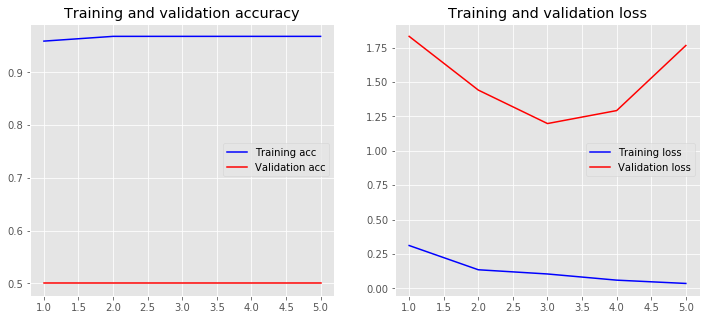

In [128]:
plot_history(history)

In [ ]:
## Can probs ignore from here down

banned_dict = {}

for word in banned_words_no_punct.split(" "):
    if word in banned_dict:
        banned_dict[word] += 1
    else:
        banned_dict[word] = 1
        
print(dict(list(banned_dict.items())[0: 5]))

In [4]:
not_banned_dict = {}

for word in not_banned_words_no_punct.split(" "):
    if word in not_banned_dict:
        not_banned_dict[word] += 1
    else:
        not_banned_dict[word] = 1
        
print(dict(list(not_banned_dict.items())[0: 5]))

{'Seriously': 52, 'The': 2331, 'pats': 6, 'havent': 245, 'won': 77}


In [5]:
banned_counts = {}
for word in list(banned_dict.keys()):
    if word in not_banned_dict:
        banned_counts[word] = banned_dict[word] - not_banned_dict[word]
        if banned_counts[word] < 0:
            banned_counts[word] = 0
    else:
        banned_counts[word] = banned_dict[word]

print(dict(list(banned_counts.items())[0: 5]))

{'I': 0, 'know': 39, 'that': 0, 'strenuous': 4, 'ever': 1}


In [6]:
not_banned_counts = {}
for word in list(not_banned_dict.keys()):
    if word in banned_dict:
        not_banned_counts[word] = not_banned_dict[word] - banned_dict[word]
        if not_banned_counts[word] < 0:
            not_banned_counts[word] = 0
    else:
        not_banned_counts[word] = not_banned_dict[word]
        
print(dict(list(not_banned_counts.items())[0: 5]))

{'Seriously': 0, 'The': 733, 'pats': 6, 'havent': 37, 'won': 66}


In [7]:
def getCounts(str):
    """
    get how many times the words show up in the banned dictionary - how many times it shows up in the not banned dictionary
    """
    weight = 0
    for word in str.split(" "):
        if word in banned_counts:
            weight += banned_counts[word]
        if word in not_banned_counts:
            weight -= not_banned_counts[word]
    return weight

In [8]:
def getBannedCount(str):
    """
    get how many times the words show up in the banned dictionary 
    """
    weight = 0
    for word in str.split(" "):
        if word in banned_counts:
            weight += banned_counts[word]
    return weight

In [9]:
def getNotBannedCount(str):
    """
    get how many times the words show up in the not banned dictionary 
    """
    weight = 0
    for word in str.split(" "):
        if word in not_banned_counts:
            weight += not_banned_counts[word]
    return weight

In [10]:
feature = []
#labels = np.array(int)
labels = []
feature1 = []
feature2 = []
feature3 = []
count = 0
for comment in banned_comments:
    if count < 10000:
        feature1.append(float(getBannedCount(comment)))
        feature2.append(float(getNotBannedCount(comment)))
        feature3.append(float(getCounts(comment)))
        labels.append(float(1))
        count += 1
    else:
        break
        #labels = np.append(labels, 1)
        
count = 0
for comment in not_banned_comments:
    if count < 10000:
        feature1.append(float(getBannedCount(comment)))
        feature2.append(float(getNotBannedCount(comment)))
        feature3.append(float(getCounts(comment)))
        labels.append(float(0))
        #labels = np.append(labels, 0)
        count += 1
    else:
        break

feature.append(feature1)
feature.append(feature2)
feature.append(feature3)
labels1 = []
labels1.append(labels)
print('done')

done


In [11]:
features = np.array([np.array(xi) for xi in feature])
type(features)

numpy.ndarray

In [12]:
label = np.array([np.array(xi) for xi in labels1])
type(label)

numpy.ndarray

In [13]:
shape_X = features.shape
shape_Y = label.shape
m = 2 * 400

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have %d training sample!' % (m))

The shape of X is: (3, 20000)
The shape of Y is: (1, 20000)
I have 800 training sample!


In [14]:
def layerSizes(X, Y):
    """
    X -- input dataset of shape 
    Y -- labels of shape
    """
    input_layer_size= X.shape[0]
    hidden_layer_size= 4
    output_layer_size= Y.shape[0]
    # hardcode as 1 bc we have to 
    
    """
    Returns:
    input_layer_size -- the size of the input layer
    hidden_layer_size -- the size of the hidden layer
    output_layer_size -- the size of the output layer
    """
    
    return (input_layer_size, hidden_layer_size, output_layer_size)

In [16]:
def initialize_parameters(input_size, hidden_size, output_size):
    """
    input_size-- size of the input layer
    hidden_size -- size of the hidden layer
    output_size-- size of the output layer
    
    
    """
    
    np.random.seed(2)  # you can pick any seed in this case
    
    Weight1 = np.random.randn(hidden_size,input_size) * 0.01
    Weight2 = np.random.randn(output_size,hidden_size) * 0.01
    bias1 = np.zeros(shape=(hidden_size, 1))
    bias2 = np.zeros(shape=(output_size, 1))
    
    parameters = {"Weight1": Weight1,
                  "bias1": bias1,
                  "Weight2": Weight2,
                  "bias2": bias2}
    
    
    """
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape 
                    b1 -- bias vector of shape 
                    W2 -- weight matrix of shape 
                    b2 -- bias vector of shape
    
    """
    
    return parameters

In [18]:
def forward_prop(X, parameters):
    """
    X -- input data of size
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    
    """
    # Retrieve each parameter from the dictionary "parameters"
    Weight1 = parameters['Weight1']
    bias1 = parameters['bias1']
    Weight2 = parameters['Weight2']
    bias2 = parameters['bias2']
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(Weight1,X) + bias1
    A1 = np.tanh(Z1)
    Z2 = np.dot(Weight2,A1) + bias2
    A2 = sigmoid(Z2)
    
    #Values needed in the backpropagation are stored in cache. Later, it will be given to back propagation.
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    
    """
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    return A2, cache

In [20]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation
    Y -- "true" labels vector of shape 
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    """
    
    m = Y.shape[1]  # number of example 

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2), Y[0]) + np.multiply((1 - Y[0]), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    
    ### Remember that, if you want to use different cross-entropy loss, you need to change logprobs and cost accordingly
    
    cost = float(np.squeeze(cost))   
    
    return cost

In [21]:
def backward_propagation(parameters, cache, X, Y):
    """
    
    parameters -- dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data 
    Y -- "true" labels vector 
    
    
    """
    m = X.shape[1]
    
    # Copy W1 and W2 from the dictionary "parameters"
    Weight1 = parameters['Weight1']
    Weight2 = parameters['Weight2']
    
        
    # Copy A1 and A2 from dictionary "cache".
    
    A1 = cache['A1']
    A2 = cache['A2']
    
    #  calculate dW1, db1, dW2, db2. 
    
    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(Weight2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    gradient = {"dW1": dW1,
                "db1": db1,
                "dW2": dW2,
                "db2": db2}
    
    return gradient

In [22]:
def update_parameters(parameters, grads, learning_rate = 0.5):
    """
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    """
    # Copy the following parameter from the dictionary "parameters"
    Weight1 = parameters['Weight1']
    Weight2 = parameters['Weight2']
    bias1 = parameters['bias1']
    bias2 = parameters['bias2']
    
    # Copy each gradient from the dictionary "grads"
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # Update rule for each parameter
    Weight1 = Weight1 - learning_rate * dW1
    Weight2 = Weight2 - learning_rate * dW2
    bias1 = bias1 - learning_rate * db1
    bias2 = bias2 - learning_rate * db2
    
    parameters = {"Weight1": Weight1,
                  "Weight2": Weight2,
                  "bias1": bias1,
                  "bias2": bias2}
    
    """
    Returns:
    parameters -- python dictionary containing your updated parameters
    """
    #print(parameters)
    return parameters

In [28]:
def model(X, Y, n_h, num_iterations = 1000, print_cost=True):
    """
    X -- dataset
    Y -- labels
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent
    print_cost -- if True, print the cost in every 100 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(4)
    n_x = layerSizes(X, Y)[0]
    n_y = layerSizes(X, Y)[2]
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    Weight1 = parameters['Weight1']
    bias1 = parameters['bias1']
    Weight2 = parameters['Weight2']
    bias2 = parameters['bias2']
    
    # gradient descent

    for i in range(0, num_iterations):
         
        # Call the Forward propagation with X, and parameters.
        A2, cache = forward_prop(X, parameters)
        
        # Call the Cost function with A2, Y and parameters.
        cost = compute_cost(A2, Y, parameters)
 
        # Call Backpropagation with Inputs, parameters, cache, X and Y.
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Update gradient descent parameter with  parameters and grads and learning rate.
        parameters = update_parameters(parameters, grads)
        
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [29]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    parameters -- python dictionary containing your parameters 
    X -- input data
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_prop(X,parameters)
    predictions = (A2 > 0.5)
    
    return predictions

In [31]:
# Build a model with a n_h-dimensional hidden layer
parameters = model(features, label, n_h = 1, num_iterations = 1000, print_cost=True)

# Plot the decision boundary
# plot_decision_boundary(lambda x: predict(parameters, x.T), features, label[0])
# plt.title("Decision Boundary for hidden layer size " + str(4));

# Print accuracy
predictions = predict(parameters, features)
print ('Accuracy: %d' % float((np.dot(label,predictions.T) + np.dot(1-label,1-predictions.T))/float(label.size)*100) + '%')

Cost after iteration 0: 0.693369
Cost after iteration 100: 0.691049
Cost after iteration 200: 0.690562
Cost after iteration 300: 0.690457
Cost after iteration 400: 0.690391
Cost after iteration 500: 0.690337
Cost after iteration 600: 0.690291
Cost after iteration 700: 0.690251
Cost after iteration 800: 0.690216
Cost after iteration 900: 0.690187
Accuracy: 51%
